# Rob Hicks: Simulation and Bayes Rules

From https://rlhick.people.wm.edu/stories/bayesian_8.html.

In [1]:
%matplotlib inline
from IPython.display import YouTubeVideo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import norm, gamma, uniform
import pymc3 as pm3
from scipy import optimize
import corner as corner
import emcee as emcee

import warnings
warnings.filterwarnings('ignore')

sbn.set_style('white')
sbn.set_context('talk')

np.random.seed(12578)

Here, I'll briefly describe some of the step methods for producing a Monte Carlo Markov Chain.  We have discussed in detail the random walk Metropolis Hastings sampler.  We will briefly discuss in a bit more detail the following samplers:

1. Gibbs Samplers
2. Metropolis Hastings Samplers  
    a. Random Walk Metropolis Hastings  
    b. Adaptive Metropolis Hastings (we won't cover)  
    c. Independent Metropolis Hastings  (we won't cover)  
    d. Slice Samplers and Other variants (we won't cover)

The nitty-gritty details of the following two samplers are beyond the scope of the course, but I will try to give you a feel for how they improve on Metropolis Hastings because they are known to be a major improvement over any of the samplers listed above even for high dimensional models (lots of coefficients to estimate):

* Hamiltonian Monte Carlo Sampler (No U-turn Sampler)
* Affine Invariant Sampler (EMCEE)

Note: This is a very fast moving topic, which means that some of the discussion here may be rendered obsolete by new developments, so be sure to check with the up-to-date documentation.

## Gibbs Sampler

The Gibbs Sampler is a special case of the Random-Walk Metropolis Hastings algorithm and one worth knowing about in a bit of detail because many tutorials and discussions about MH (especially older ones) are entertwined with  discussions on Gibbs sampling and it can be confusing for the uninitiated.  Despite this being a special case of MH, it is worth seeing how it works in a bit of detail.  The idea is to successively sample *each* $\theta$ from its conditional distribution:

\begin{align}
\theta^{t+1}_1 \sim & f_1(\theta^{t+1}_1 \mid \theta^{t}_2,\theta^{t}_3,\ldots, \theta^{t}_k,\mathbf{y},\mathbf{x}) \\
\theta^{t+1}_2 \sim & f_2(\theta^{t+1}_2 \mid \theta^{t+1}_1,\theta^{t}_3,\ldots, \theta^{t}_k,\mathbf{y},\mathbf{x}) \\
\theta^{t+1}_3 \sim & f_3(\theta^{t+1}_3 \mid \theta^{t+1}_1,\theta^{t+1}_2,\ldots, \theta^{t}_k,\mathbf{y},\mathbf{x})\\
&\vdots \\
\theta^{t+1}_k \sim & f_k(\theta^{t+1}_k \mid \theta^{t+1}_1,\theta^{t+1}_2,\theta^{t+1}_3\ldots, \theta^{t+1}_{k-1},\mathbf{y},\mathbf{x})
\end{align}

where each parameter $i$ has a conditional distribution function $f_i$.

First consider this simple example, where our parameters to be estimate are $\theta = [\mu,\sigma]$ and where we have flat priors:

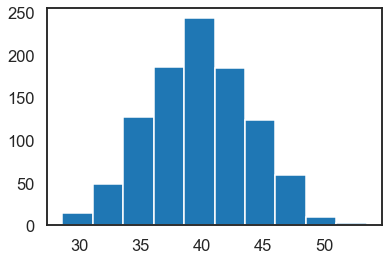

In [2]:
# data: construct toy data matrix
N = 1000
Y = norm(40,4).rvs(N)
plt.hist(Y);

When we employ a Gibbs Sampler, all samples are accepted (there are versions of the Gibbs Sampler that use a rejection based approach- not covered here).  This is accomplished by choosing problems where the conditional distributions:

\begin{align}
f_\mu(\mu | \sigma, \mathbf{Y}) \\
f_\sigma(\sigma | \mu, \mathbf{Y})
\end{align}

are known and have closed form solutions.  For example, if we have 

\begin{equation}
f_\mu(\mu | \sigma, \mathbf{Y}) = \phi \left ( \frac{\mathbf{Y} - \mu}{\sigma} \right )
\end{equation}
that is, Y is distributed normal with mean $\mu$ and standard deviation $\sigma$, then it can be shown that
\begin{equation}
f_\sigma \left(\sigma^2 | \mu, \mathbf{Y}\right ) = InverseGamma(k,s)
\end{equation}

where $k$ and $s$, the shape and scale parameters for the Inverse Gamma Distribution are
\begin{align}
k &= \frac{n}{2} \\
s &= \left (\frac{(Y-\mu)^2}{2} \right )^{-1}
\end{align}

The Gibbs Sampler then proceeds as follows:
1. Start the sampler at an arbitrary starting value for $\theta$. In my code below, I start the Gibbs sampler at $\theta_0 = [\mu_0=30,\sigma_0=3]$.
2. Draw the next (always accepted) value of $\sigma_t$ by:
    1. Draw random variate from a $\Gamma(k,s) = \Gamma \left ( \frac{n}{2},\left (\frac{(Y-\mu_{t-1})^2}{2} \right )^{-1} \right )$ and denote as $g$
    2. Define $var_t = \frac{1}{g}$
3. Draw the next (always accepted) value of $\mu_t$ by:
    1. Draw a normal random variate having mean $\bar{Y}$ and standard deviation $\sqrt{\frac{var_t}{n}}$ and denote as $\mu_t$.
4. Store the values $[\mu_t,\sqrt{var_t}]$ as the next sampled values for $\mu$ and $\sigma$.    

Important thing to note about this process:
1.  Gibbs sampling depends on our ability to analytically solve for conditional distributions.
2.  This involves derivations in mathematical statistics
3.  Once we have these closed form solutions, we can accept every sampled draw

In [3]:
chain_len = 10000
burnin = 1000

In [4]:
# store chains here:
mu_chain_gibbs =np.zeros((chain_len+burnin,1)) 
sigma_chain_gibbs = np.zeros(mu_chain_gibbs.shape)

# starting guesses for mu
mu_old = 40

for i in np.arange(chain_len+burnin):
    gamma_new = gamma(len(Y)/2,scale=1/np.sum(((Y-mu_old)**2)/2)).rvs()
    var_new = 1/gamma_new
    mu_new = norm(np.mean(Y), np.sqrt(var_new/len(Y))).rvs(1)
    mu_chain_gibbs[i] = mu_new
    sigma_chain_gibbs[i] = np.sqrt(var_new)
    # reset old values
    mu_old,var_old = mu_new,var_new

In [5]:
# convert to pandas dataframe
chain_gibbs = pd.DataFrame(np.append(mu_chain_gibbs,sigma_chain_gibbs,1),columns=['mean','std'])
# calculate summary statistics post burn-in
chain_gibbs.loc[burnin:].describe(percentiles=[.025,.5,.975])

mean           std
count  10000.000000  10000.000000
mean      39.805775      4.098301
std        0.129122      0.091833
min       39.305744      3.778357
2.5%      39.557243      3.927042
50%       39.805870      4.096343
97.5%     40.058110      4.286209
max       40.273004      4.507727

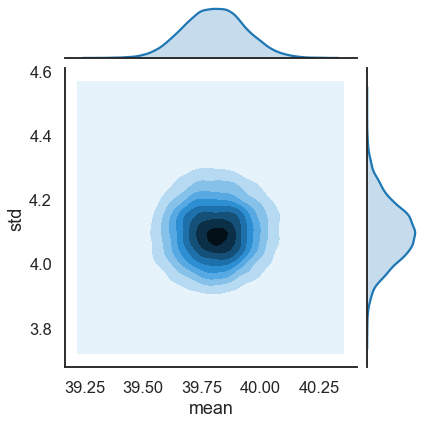

In [6]:
plot_gibbs = chain_gibbs.loc[burnin:]
plot_gibbs.head()
sbn.jointplot(x='mean', y='std', data=plot_gibbs, kind="kde");

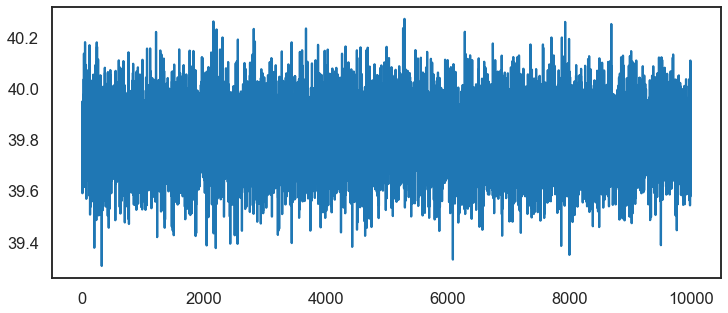

In [7]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(chain_len),plot_gibbs['mean'])
plt.show()

The Gibbs Sampler was the predominant sampling method early on in applied Bayesian statistics because it was the empirical analogue of conjugate priors (the focus of Bayesian Statistics before the computer age) and does have real advantages over MH Random Walk for problems having solvable conditional distributions, since it accepts every sample and can be more efficient (less computing time to reach convergence and inference).  

Despite this, both the Gibbs Sampler and the MH Sampler are less than ideal for
1. High dimensional problems (many parameters)
2. High correlation amongst parameters

## Bayesian OLS Regression applied to Tobias and Koop

We now turn our attention back to MH Random Walk sampling using a real dataset.

In [8]:
tobias_koop=pd.read_csv('https://rlhick.people.wm.edu/econ407/data/tobias_koop_t_4.csv')
tobias_koop['ones'] = 1
tobias_koop.head()

id  educ  ln_wage  pexp  time  ability  meduc  feduc  broken_home  \
0   4    12     2.14     2     4     0.26     12     10            1   
1   6    15     1.91     4     4     0.44     12     16            0   
2   8    13     2.32     8     4     0.51     12     15            1   
3  11    14     1.64     1     4     1.82     16     17            1   
4  12    13     2.16     6     4    -1.30     13     12            0   

   siblings  pexp2  ones  
0         4      4     1  
1         2     16     1  
2         2     64     1  
3         2      1     1  
4         5     36     1

In [9]:
# sanity check on data:
from statsmodels.regression.linear_model import OLS
ols_res = OLS(tobias_koop.ln_wage,tobias_koop[['educ','pexp','pexp2','broken_home','ones']]).fit()
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ln_wage   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     51.36
Date:                Wed, 19 Jun 2019   Prob (F-statistic):           1.83e-39
Time:                        02:03:06   Log-Likelihood:                -583.66
No. Observations:                1034   AIC:                             1177.
Df Residuals:                    1029   BIC:                             1202.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
educ            0.0853      0.009      9.179      0.000       0.067       0.104
pexp            0.2035      0.024      8.629      0.000       0.157       0.250
pexp2          -0.0124      0.002     -5.438      0.000      -0.017      -0.008
broken_home    -0.0087      0.036     -0.244      0.807      -0.079       0.061
ones            0.4603      0.137      3.353      0.001       0.191       0.730
==============================================================================
Omnibus:                       55.892   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.050
Skew:                          -0.355   Prob(JB):                     4.66e-25
Kurtosis:                       4.448   Cond. No.                         391.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is the model statement describing priors and the likelihood.  Here, we have 4 `beta` variables and `sigma` defines stochastic variables (we want a chain of sampled values for all of these variables) and we provide a prior distribution and hyper-parameters for **each variable**.  The likelihood function is chosen to be Normal, having mean denoted as `mu` (which is defined as $\mathbf{x}\beta$, having standard deviation $\sigma$ (denoted as `sigma`).  Our "dependent variable" is given by `observed=tobias_koop.ln_wage`, where `tobias_koop.ln_wage` is the log of wage from the Tobias and Koop dataset loaded above.  In more formal terms, the code below sets up a `basic_model` having the following form:

\begin{align}
Prob(\mu|\sigma,\mathbf{data}) \propto& Prob(\mathbf{data}|\mu,\sigma) \times Prob(\sigma | \mu^0_\sigma, \sigma^0_\sigma) \times Prob(\text{prior on }\beta) \\
Prob(\mu|\sigma,\mathbf{data}) \propto& \phi \left( \frac{\mathbf{ln\_wage} - \mathbf{x}\beta}{\sigma} \right ) \times HalfNormal \left(\frac{\sigma - \mu^0_\sigma}{\sigma^0_\mu} \right ) \times C \\
Prob(\mu|\sigma,\mathbf{data}) \propto& \phi \left( \frac{\mathbf{ln\_wage} - \mathbf{x}\beta}{\sigma} \right ) \times HalfNormal \left(\frac{\mu - 0}{10} \right ) 
\end{align}
where $\phi(.)$ is the standard normal pdf. The constant C (the joint probability of the prior on our $\beta$'s) is invariant with changes in our chain, and can therefore be dropped.

In [10]:
ols_model = pm3.Model()

with ols_model:

    # Priors for unknown model parameters
    beta_0 = pm3.Flat('Intercept')
    beta_1 = pm3.Flat('Educ')
    beta_2 = pm3.Flat('Pexp')
    beta_3 = pm3.Flat('Pexp2')
    beta_4 = pm3.Flat('Broken Home')
    sigma = pm3.HalfNormal('sigma', sd=10)
    
    mu = beta_0 + beta_1*tobias_koop.educ + beta_2*tobias_koop.pexp + \
         beta_3*tobias_koop.pexp2 + beta_4*tobias_koop.broken_home
    
    # Likelihood (sampling distribution) of observations
    ln_wage = pm3.Normal('ln_wage', mu=mu, sd=sigma, observed=tobias_koop.ln_wage)

## Metropolis-Hastings Random Walk

In [11]:
chain_length = 20000 

with ols_model:
    
    start = pm3.find_MAP()
    print(start)
    
    # instantiate sampler
    step = pm3.Metropolis() 

    # draw posterior samples
    trace_mh = pm3.sample(chain_length, step=step, start=start, progressbar=True) 

logp = -586.21, ||grad|| = 44.921: 100%|██████████| 76/76 [00:00<00:00, 2126.70it/s]          


{'Intercept': array(0.46033436), 'Educ': array(0.08527245), 'Pexp': array(0.20352106), 'Pexp2': array(-0.01241256), 'Broken Home': array(-0.00872437), 'sigma_log__': array(-0.85446739), 'sigma': array(0.42550976)}


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [Broken Home]
>Metropolis: [Pexp2]
>Metropolis: [Pexp]
>Metropolis: [Educ]
>Metropolis: [Intercept]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:31<00:00, 2619.35draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


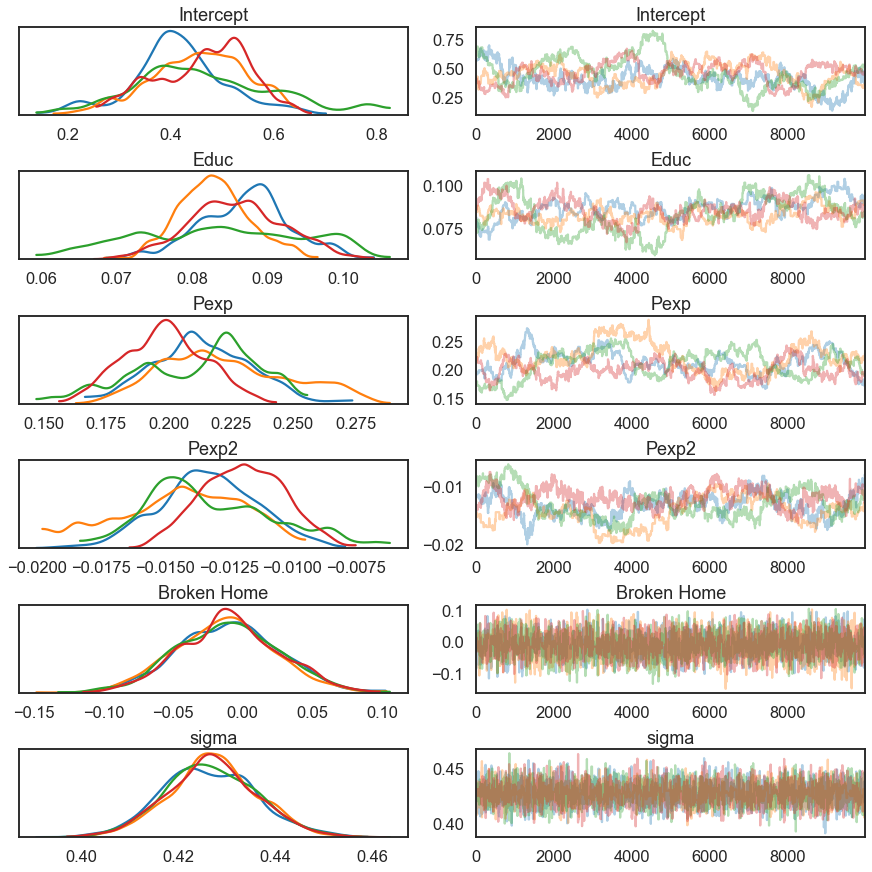

In [12]:
pm3.traceplot(trace_mh[10000:]);

In [13]:
pm3.summary(trace_mh[10000:])

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
Intercept    0.450113  0.106964  0.009717  0.242397  0.659109    36.848238   
Educ         0.084840  0.007577  0.000688  0.070745  0.101251    26.911959   
Pexp         0.211388  0.023438  0.002140  0.163511  0.255683    32.884362   
Pexp2       -0.013196  0.002325  0.000209 -0.017546 -0.008269    31.351654   
Broken Home -0.010699  0.035920  0.000691 -0.081340  0.058499  2993.771979   
sigma        0.426920  0.009302  0.000152  0.409047  0.445231  3434.451661   

                 Rhat  
Intercept    1.026018  
Educ         1.034401  
Pexp         1.103269  
Pexp2        1.105145  
Broken Home  1.001480  
sigma        1.001061

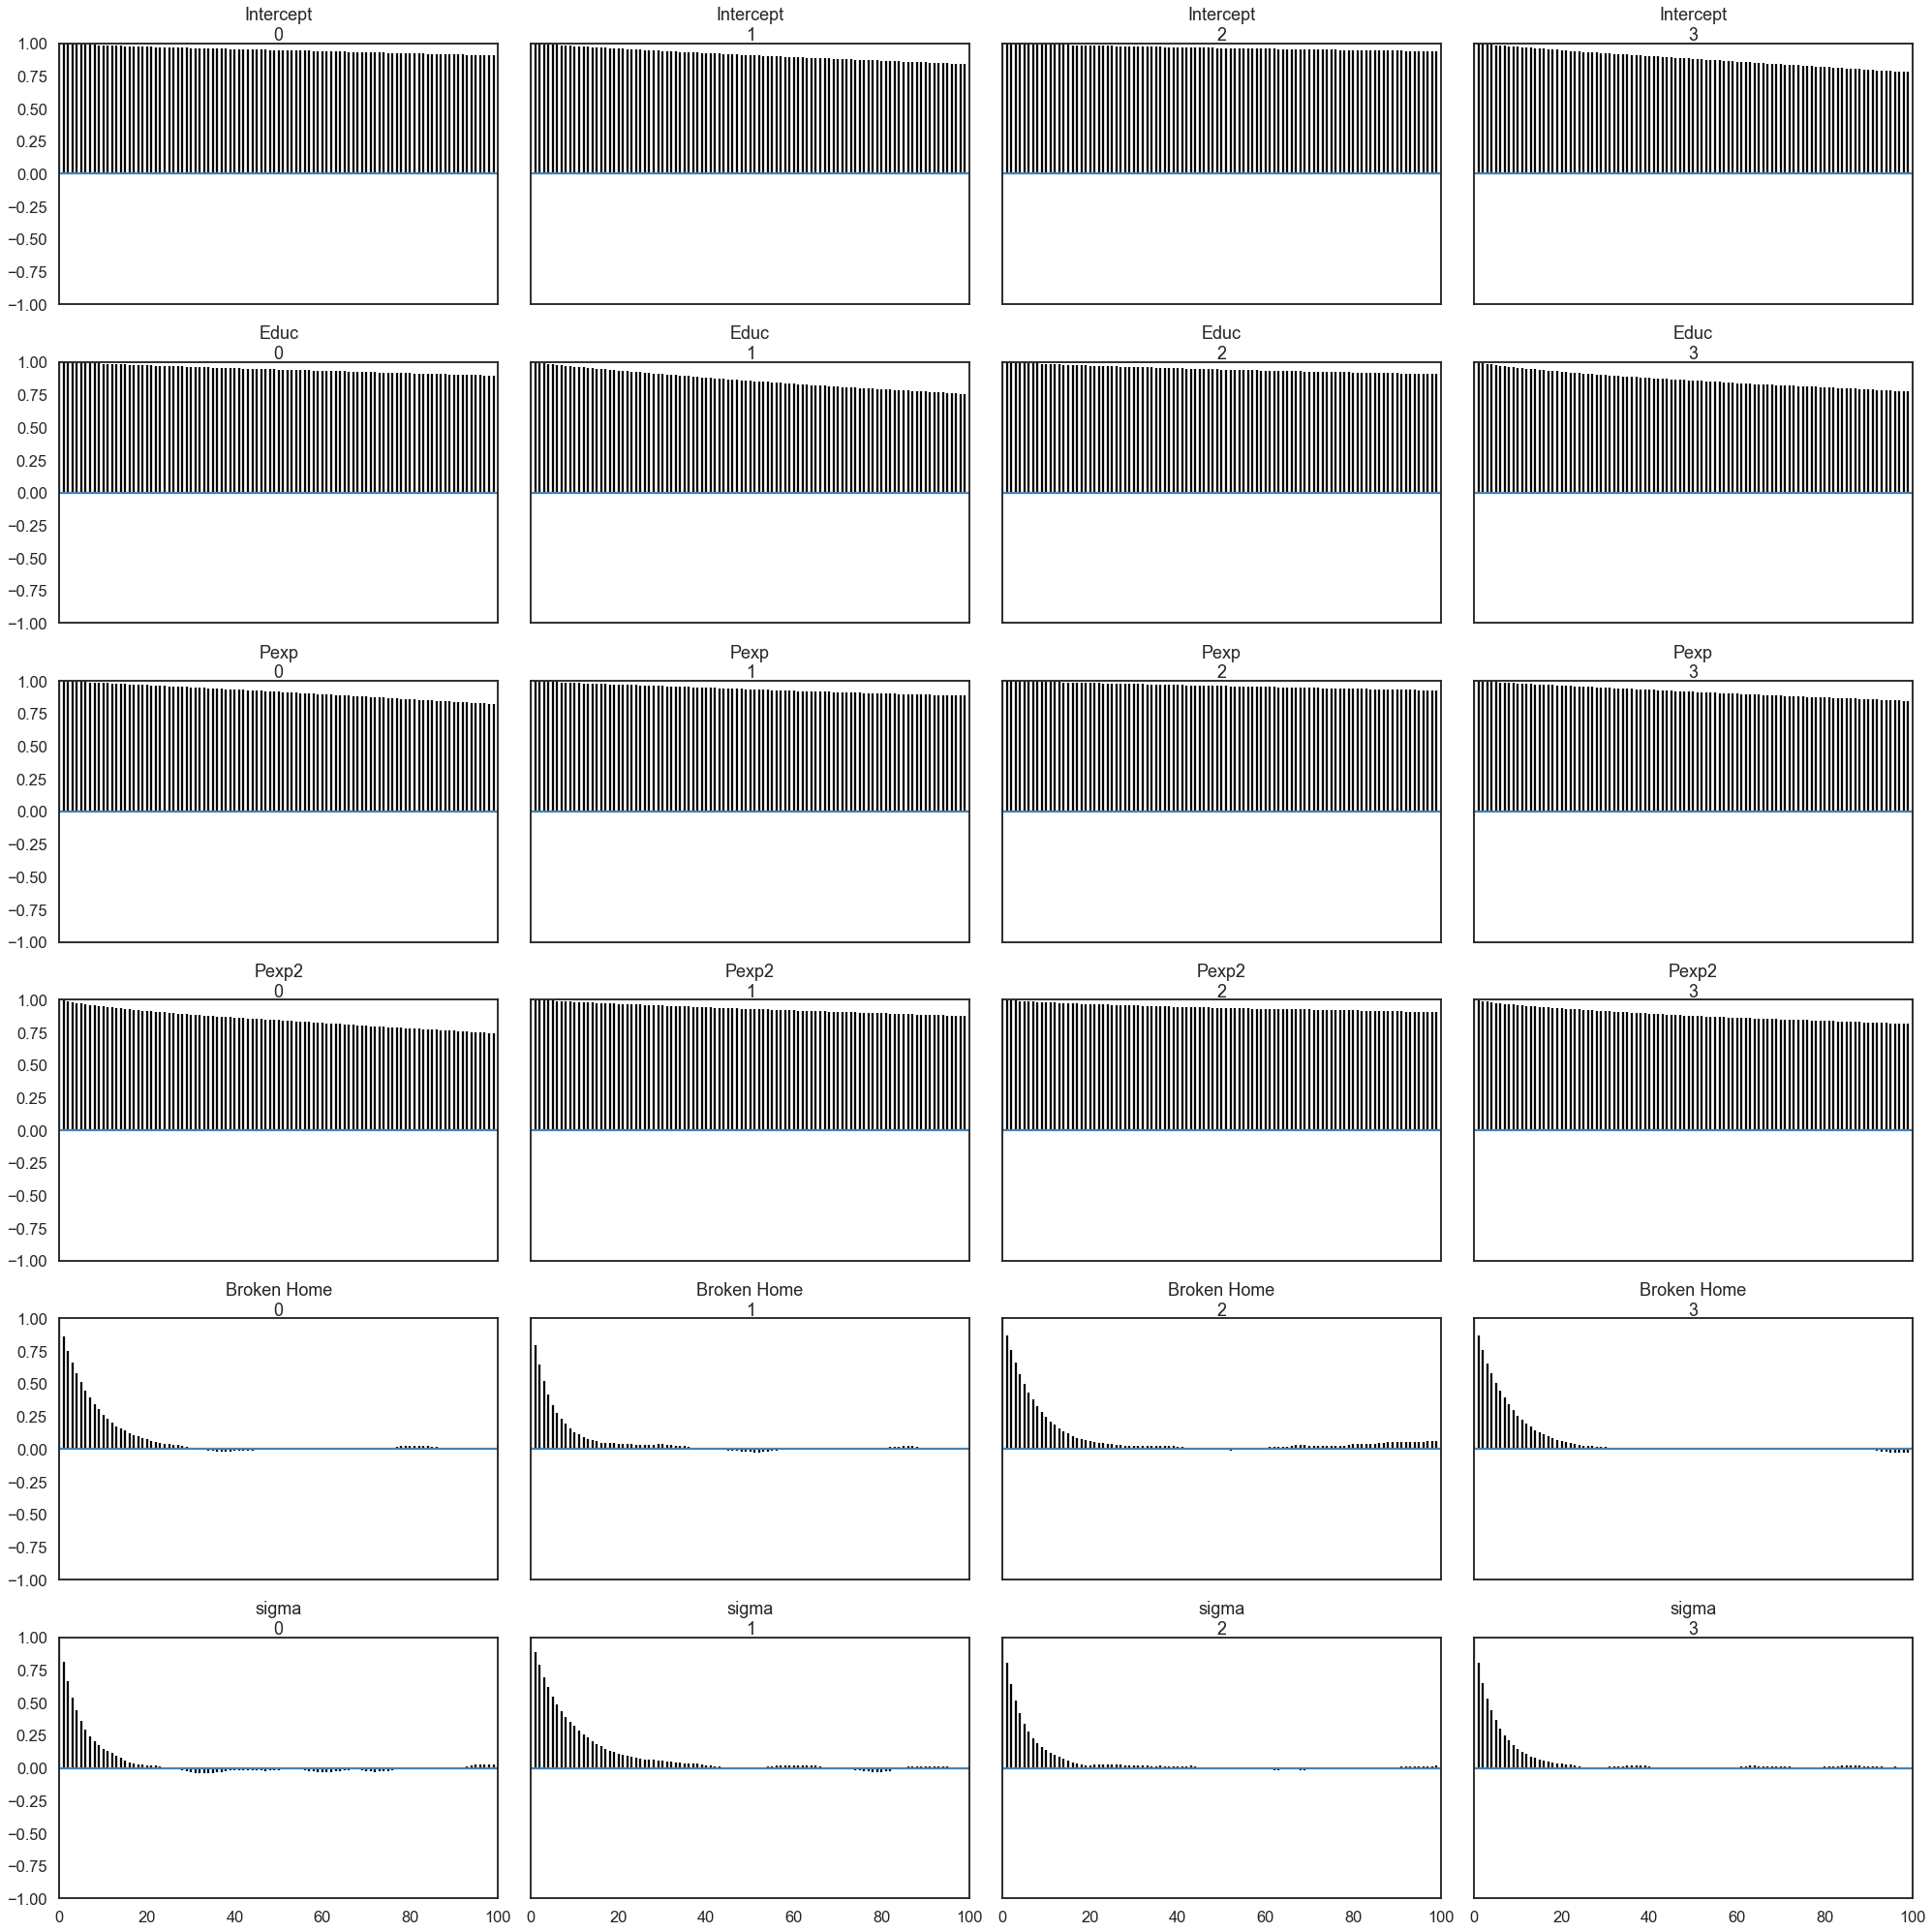

In [14]:
pm3.autocorrplot(trace_mh[2000:]);

In [15]:
pm3.gelman_rubin(trace_mh[10000:])

{'Intercept': 1.0260183728347383,
 'Educ': 1.034400595003248,
 'Pexp': 1.1032687620431756,
 'Pexp2': 1.105145018527447,
 'Broken Home': 1.0014801301257015,
 'sigma': 1.0010608510650059}

In [16]:
scores = pm3.geweke(trace_mh[10000:])

In [17]:
# create plot for each variable:
# varnames = list(scores[0])
# varnames.remove('sigma_log__') #sigma_log__ is nuisance variable, ignore
# chainids = scores.keys()
# colors_for_chains = ['k','g','b']

# plt.figure(figsize=(10,15))
# plt.subplots_adjust(top=0.85)
# plt.suptitle('Geweke Plot',fontsize=25)

# plotnum = 1
# for i in varnames:
#     plt.subplot(len(varnames),1,plotnum)
#     plt.title(i)
#     for j in chainids:
#         plt.scatter(scores[j][i][:,0],scores[j][i][:,1],s=50,c=colors_for_chains[j])
 
#     plt.axhline(-1.98, c='r')
#     plt.axhline(1.98, c='r')
#     plt.ylim(-2.5,2.5)
#     plt.xlim(-50,4050)
#     plotnum+=1

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])


I like visualizing my distributions using the `corner` plot function.  To do that, convert your chains into a pandas dataframe:

In [18]:
data = np.column_stack((trace_mh[10000:]['Intercept'],trace_mh[10000:]['Educ'],
             trace_mh[10000:]['Pexp'],trace_mh[10000:]['Pexp2'],
             trace_mh[10000:]['Broken Home'],trace_mh[10000:]['sigma']))
pairplot_dat = pd.DataFrame(data,columns=['Intercept','Educ','Pexp','Pexp2','Broken Home','sigma'])

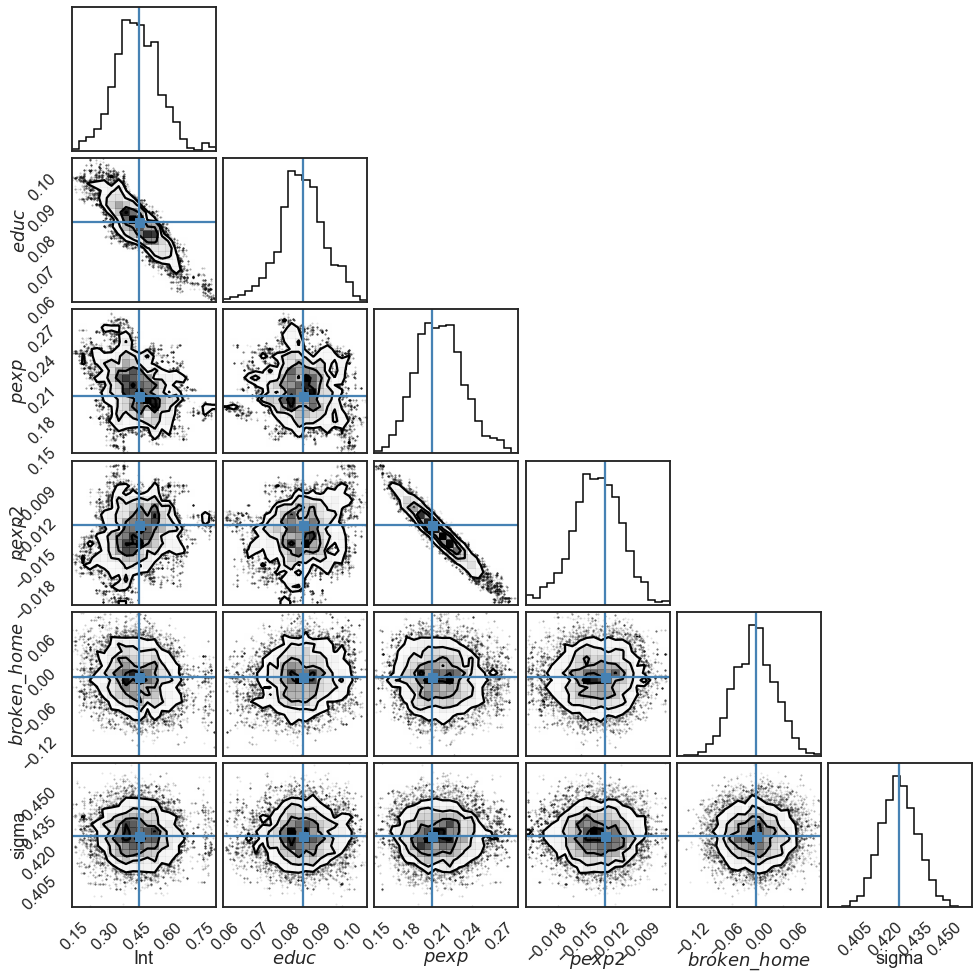

In [19]:
fig = corner.corner(pairplot_dat, labels=["Int", "$educ$", "$pexp$", "$pexp2$","$broken\_home$","sigma"],
                      truths=[.4603, .0853, .2035, -.0124, -.0087, np.sqrt(ols_res.mse_resid)])

What is the problem?  We have what appears to be a converged chain that gives us back what we expect if we compare to the OLS results.  Diving into the details of the sampler, one can see that MH Random Walk, even for this relatively simple model has some pairs of parameters that have high covariance.  Focusing on the `Intercept` and `Educ`, the following video shows the evolution of our chain for each of these two variables, and how it explores the probability surface:

## Hamiltonian Monte Carlo and the No U-turn Sampler

Hamiltonian Monte Carlo was developed initially in the field of particle physics for simulating the movement of molecules in three dimensions.  It is trivially extended to $k$ dimensions (our parameter space).  This step method adds an auxiliary parameter for each model parameter and therefore doubles the parameter space in a way that actually makes the exploration of the posterior more efficient. These auxiliary parameters (nuisance parameters) are discarded after estimation.  Our original model parameters (helps us to define *potential energy* which is the posterior probability) and these auxiliary parameters (helps us define *kinetic energy*), which aid in a more efficient exploration of the parameter space.  An excellent discussion of Hamiltonian Monte Carlo is [here](http://www.mcmchandbook.net/HandbookChapter5.pdf) and the paper extending Hamiltonian Monte Carlo to the No U-Turn Sampler is [here](http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf).  These don't make for light reading and are not required for this course.

>The idea: rather than blindly stumbling around the posterior, use the posterior gradiant to *skate* around the gradiant contour.  As you skate closer to a drop-off (gradiant is steep and probability is lower), potential energy decreases and kinetic energy increases (since energy is always conserved).  When this happens the skater is turned back uphill and pushed from the precipice and skates on along a posterior likelihood contour.  The No U-Turn sampler keeps skating until the skater tries to turn back towards the original point.

One trick to applying this method is to ensure that proposals lead to accepted samples that satisfy the Ergodic Theorem.  The papers above go into that topic.  In short, they mostly do.  


Using pymc3, we can implement NUTS as:

In [20]:
with ols_model:
    start = pm3.find_MAP()
    print(start)
    # declare sampler here. Comment out for auto assignment
    step = pm3.NUTS() 
    
    # draw posterior samples
    trace_NUTS_ols = pm3.sample(2000, step=step, start=start) 

logp = -586.21, ||grad|| = 44.921: 100%|██████████| 76/76 [00:00<00:00, 2054.44it/s]          


{'Intercept': array(0.46033436), 'Educ': array(0.08527245), 'Pexp': array(0.20352106), 'Pexp2': array(-0.01241256), 'Broken Home': array(-0.00872437), 'sigma_log__': array(-0.85446739), 'sigma': array(0.42550976)}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Broken Home, Pexp2, Pexp, Educ, Intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:33<00:00, 301.23draws/s]
The acceptance probability does not match the target. It is 0.8839237385160597, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909787481181458, but should be close to 0.8. Try to increase the number of tuning steps.


This same model can be run using `glm` (general linear model):

In [21]:
glm_model = pm3.Model()

with glm_model:
    pm3.glm.GLM.from_formula('ln_wage ~ educ + pexp + pexp2 + broken_home', tobias_koop)
    start = pm3.find_MAP()
    print(start)
    
    step = pm3.NUTS() # Instantiate MCMC sampling algorithm
    trace_NUTS = pm3.sample(2000, step, progressbar=True, start=start)

logp = -618.03, ||grad|| = 328.16: 100%|██████████| 59/59 [00:00<00:00, 411.16it/s]  


{'Intercept': array(0.46039977), 'educ': array(0.08526432), 'pexp': array(0.20354059), 'pexp2': array(-0.01241491), 'broken_home': array(-0.00869693), 'sd_log__': array(-0.85445693), 'sd': array(0.42551421)}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, broken_home, pexp2, pexp, educ, Intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [01:13<00:00, 135.74draws/s]
The acceptance probability does not match the target. It is 0.8843579220378841, but should be close to 0.8. Try to increase the number of tuning steps.


In [22]:
pm3.summary(trace_NUTS)

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
Intercept    0.457611  0.137615  0.002039  0.195793  0.739809  4269.568121   
educ         0.085408  0.009230  0.000135  0.066560  0.103019  4820.949433   
pexp         0.203873  0.023547  0.000341  0.160187  0.252102  4168.797478   
pexp2       -0.012446  0.002269  0.000032 -0.016912 -0.008025  4307.531424   
broken_home -0.008154  0.035375  0.000449 -0.078295  0.058910  5921.717430   
sd           0.427042  0.009204  0.000103  0.408664  0.444684  6707.220898   

                 Rhat  
Intercept    1.000067  
educ         1.000244  
pexp         1.000009  
pexp2        1.000005  
broken_home  0.999832  
sd           0.999951

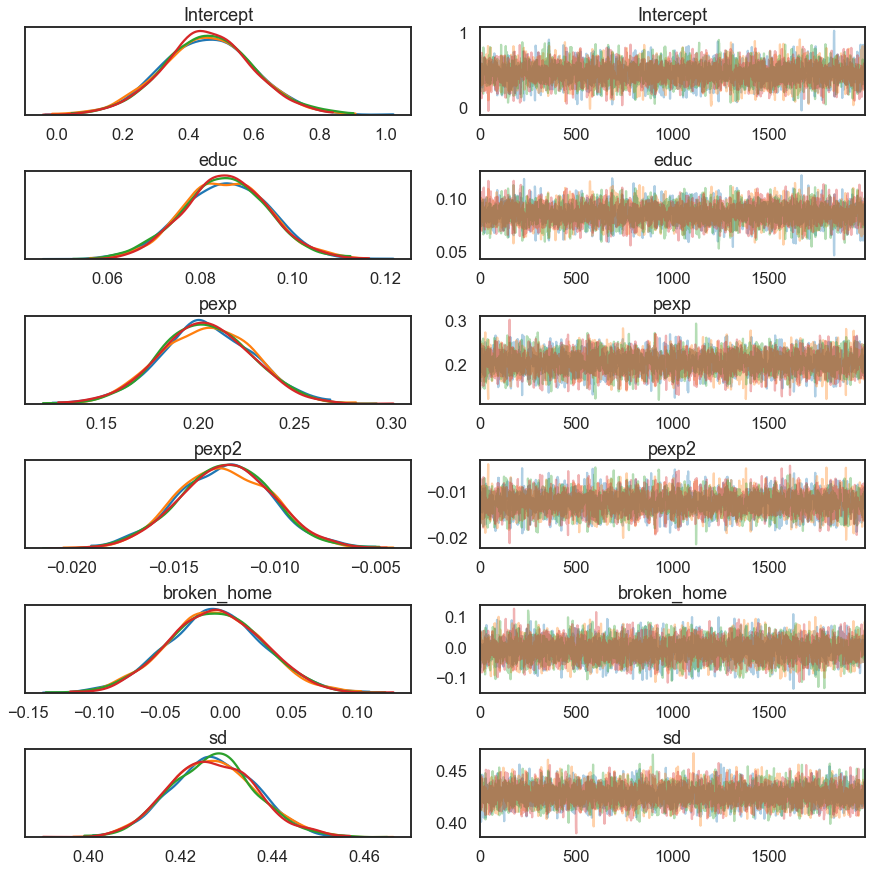

In [23]:
pm3.traceplot(trace_NUTS);

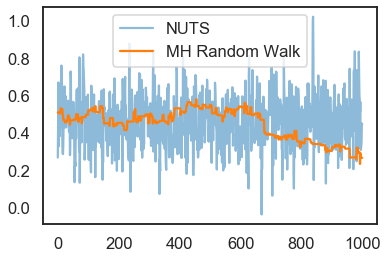

In [24]:
plt.plot(np.arange(1000),trace_NUTS['Intercept'][1000:2000],label='NUTS',alpha=.5)
plt.plot(np.arange(1000),trace_mh['Intercept'][2000:3000],label='MH Random Walk')
plt.legend();

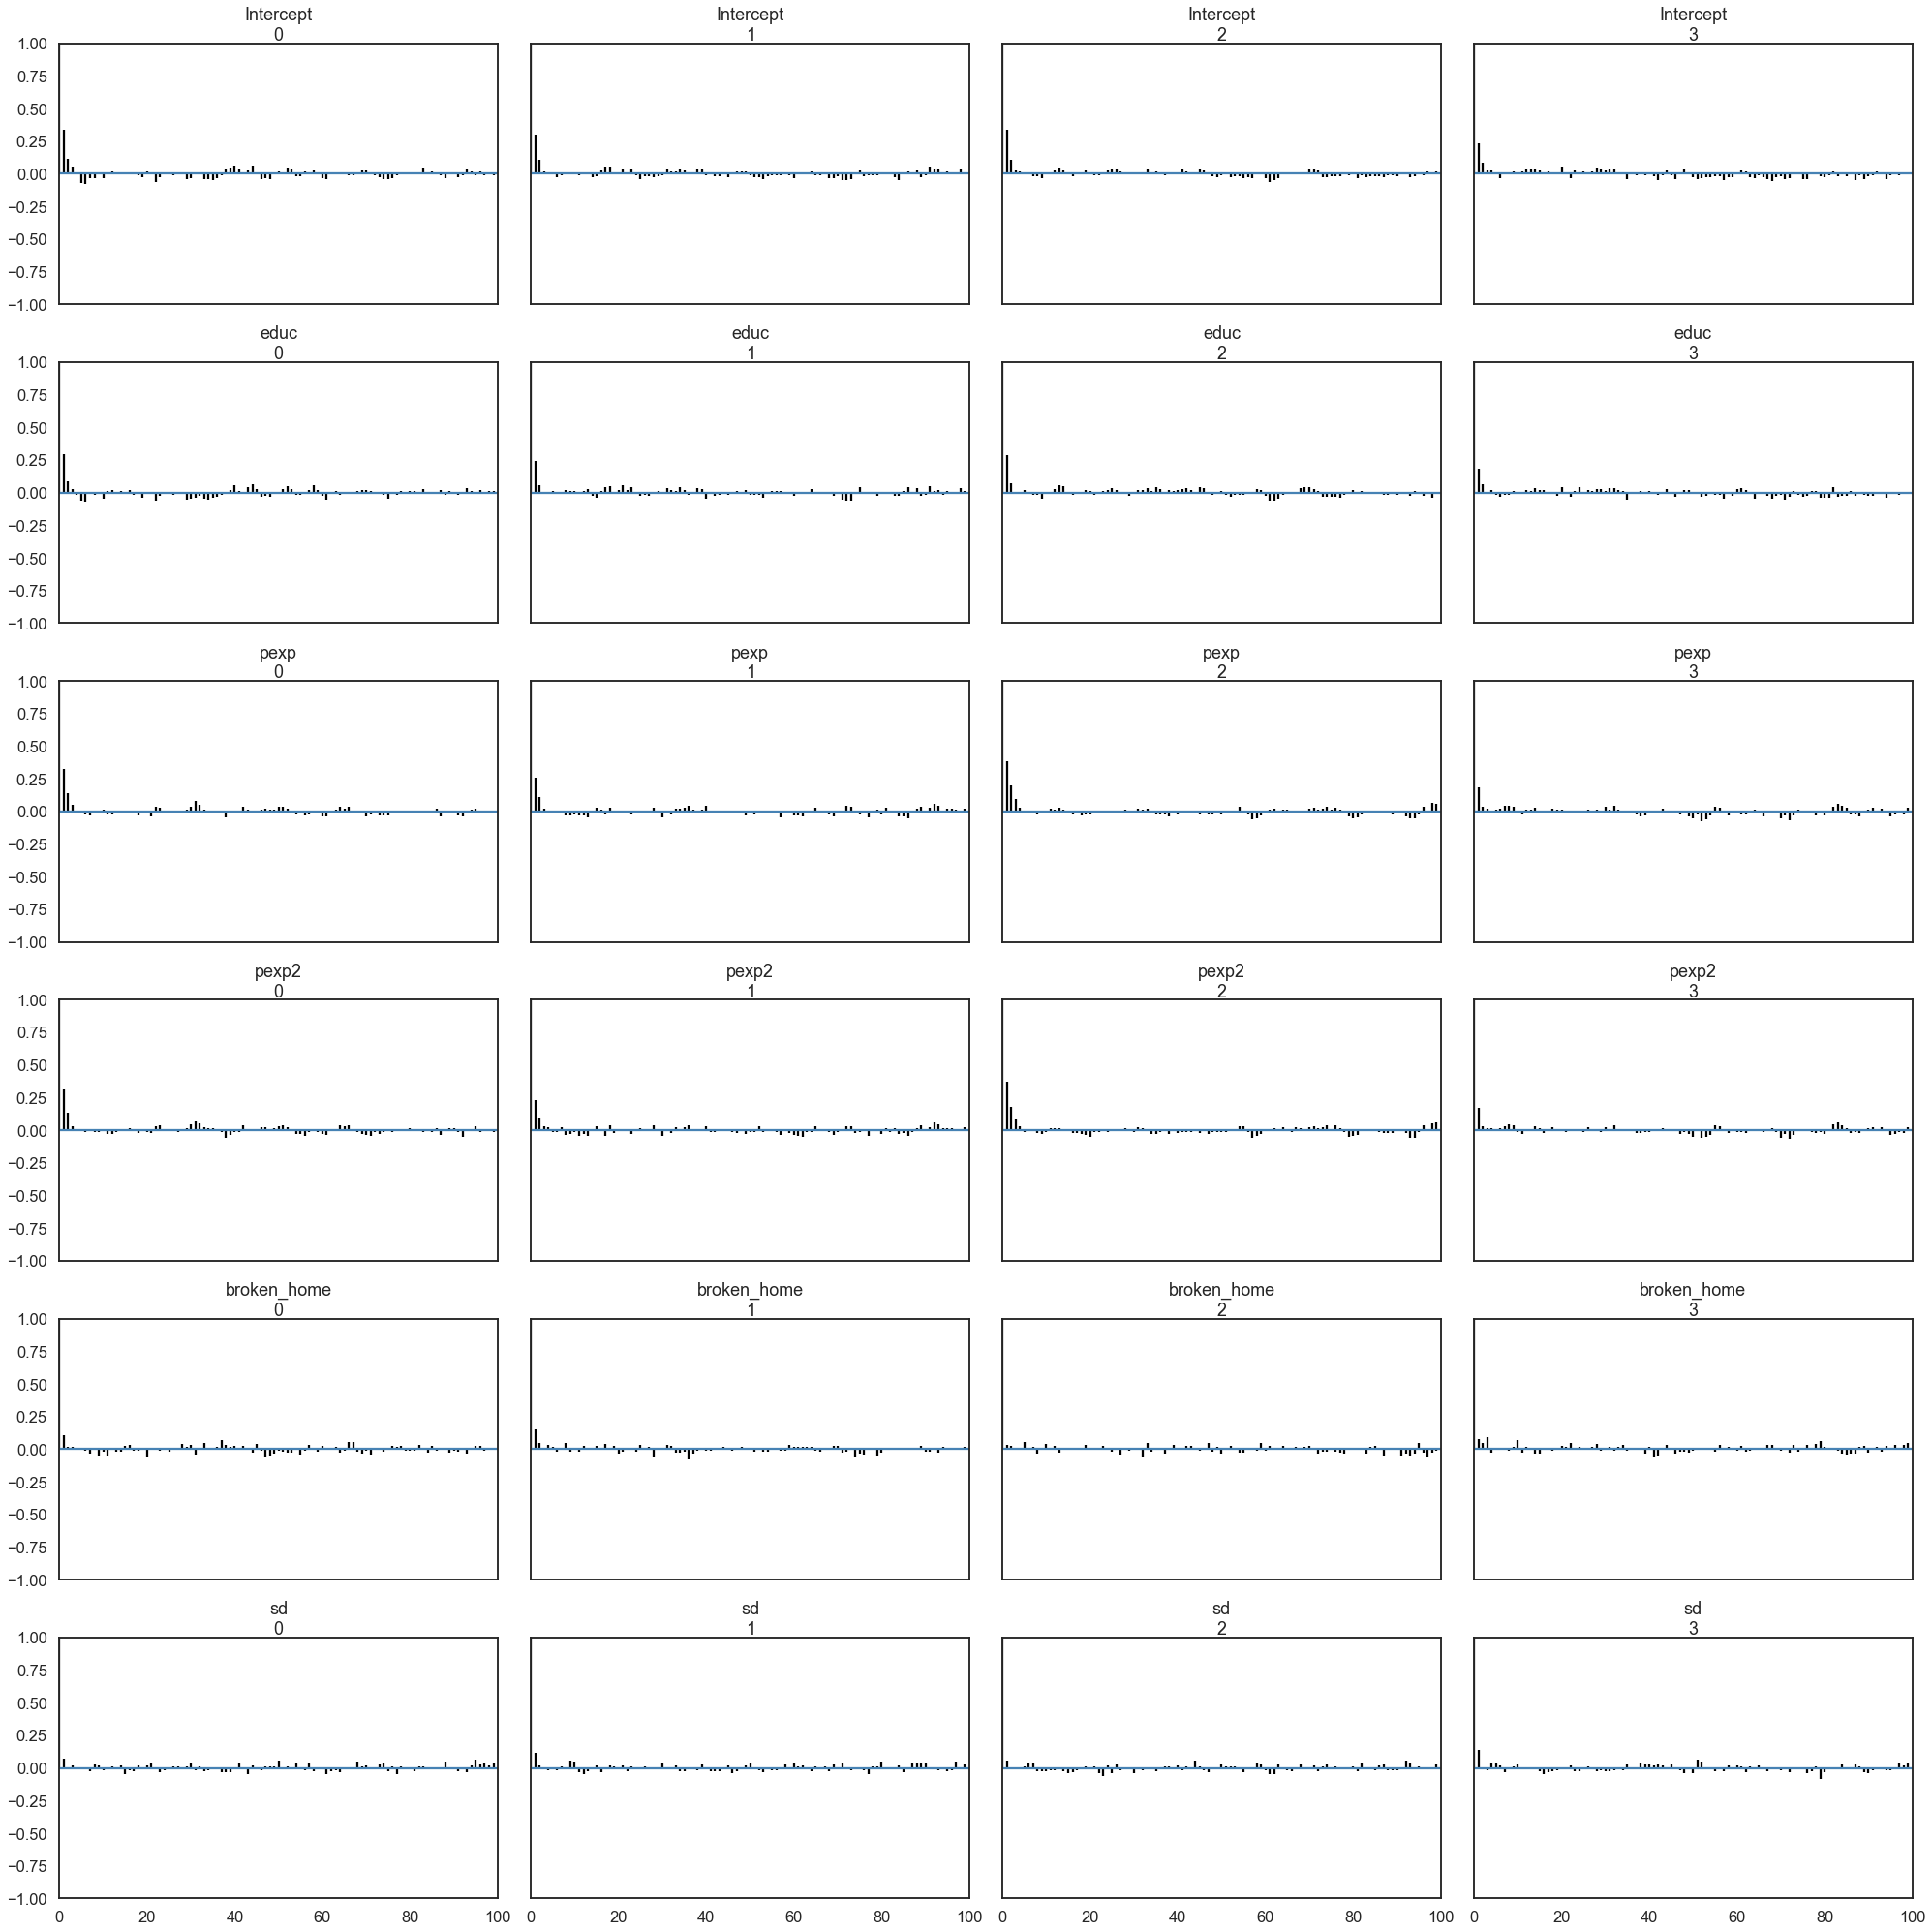

In [25]:
pm3.autocorrplot(trace_NUTS);

So per unit work (per second of computer time), we explore the posterior much more efficiently using NUTS.  Here's the video:

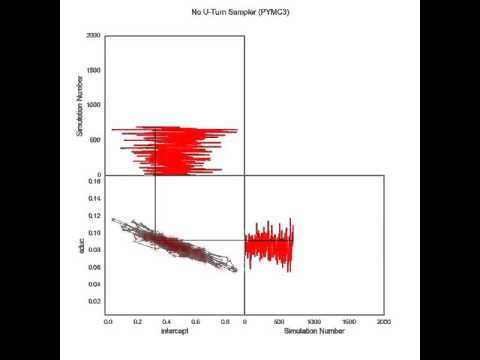

In [26]:
YouTubeVideo('yV39VGmoZxw')

A caveat to NUTS as implemented in PyMC3:

> NUTS uses a package called Theano (totally in the background) for compiling your model into faster code.  While that is nice, sometimes the error messages you might get are less than illuminating.

The following shows the performance of NUTS (versus MH Random Walk) for a variety of interesting posterior shapes:

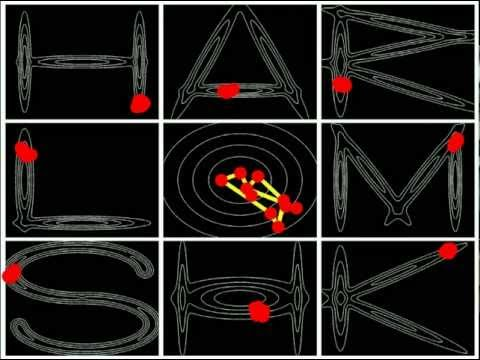

In [27]:
YouTubeVideo('Vv3f0QNWvWQ')

## EMCEE (Affine Invariant Ensemble Sampler Monte Carlo Markov Chain)

> Also known as the `hammer`.

EMCEE, along with NUTs, demonstrate the forefront of current methodologies for constructing MCMC's.  EMCEE takes a different approach than the NUTs, which is inspired by the movement of molecules in three dimensions.  EMCEE constructs the chain by simultaneously unleashing a number of walkers that share information about the posterior in a way that preserves Ergodicity and the properties we need to use our chain for inference.  Unlike all nearly every other sampling method, it can do this using parallel computation making it possible to do MCMC inference on large-scale clusters (supercomputers) or machines having many processor cores.

Earlier in the class, I demonstrated that the `njobs` option in `pymc3` could be used to parallelize `pymc3` but it needs to be reiterated that this is constructing 3 independent chains and combining them can be done once chain convergence is assessed and validated.  In contrast, EMCEE produces a chain from the get-go that can combine work done across a large number of processor cores.  This makes EMCEE a very strong option for computationally expensive problems.  At present, this is not implemented in `pymc3`, unfortunately, but as of March 2018, it is unavailable but work is ongoing.

The mathematics behind EMCEE can be found in the [paper here](https://arxiv.org/abs/1202.3665) and it has been used extensively in astro-physics.  Rather than spend a lot of time with the details, I'll give you an idea of how the sampler works.  It should be noted that like NUTs, we are talking about how proposals are determined- once we have a proposal, the accept/reject criteria follows Metropolis-Hastings.

> Idea: For a $K$ parameter problem, let there be $W$ walkers.  You can think of each walker as being an MCMC chain.  Proposals for a walker are found by randomly choosing another walker location and leap-frogging towards it.  The length of the jump is determined by the relative likelihood of the two proposal values.  A lower likelihood and the walker will leap between its current position and the sampled walker. If higher, it can leap over the sampled walkers position.

Some intuition: In the walking dead, walkers are constantly roaming the landscape looking for victims.  When a walker runs into a victim, the other walkers tend to go towards it and wander in that area in a frenzy.  If we think of victims as high posterior areas, then the walkers will bounce around good areas almost in a swarm.

### Implementing EMCEE in code

Unfortunately, EMCEE is not implemented in `pymc3`, so we have to install it in our Anaconda environment:
```
conda install emcee
```

Once installed, the process for setting up the problem is similar to pymc3 in abstract, but differs quite a bit in construction

In [28]:
# to make likelihood calculations easier, add a column of ones for the intercept:
tobias_koop['ones'] = 1

In [29]:
# Likelihood Function for OLS 
#  Note: your parameters must come first: 
def log_likelihood(theta, x, y):
    sigma = np.asmatrix(theta[-1])         #the last element of theta is the std dev of epsilon, and can't be <0
    beta = np.asarray(theta[:-1])          #the first k are beta parameters
    
    if sigma <= 0:
        return -1*np.inf
    else: 
        mu = np.dot(tobias_koop[x],beta).reshape(tobias_koop.shape[0],1) #this is xb
        return norm(mu,sigma).logpdf(tobias_koop[y]).sum() 

# assume flat priors on beta's        
def log_prior_beta(theta):
    return np.log(1)

# assume positive uniform prior on sigma
def log_prior_sigma(theta):
    sigma = np.asmatrix(theta[-1])         #the last element of theta is the std dev of epsilon, and can't be <0
    beta = np.asarray(theta[:-1])          #the first k are beta parameters
    if sigma <= 0:
        return -1*np.inf                     #account for a chain trying to assign sigma < 0: penalize heavily
    else:
        return np.log(1)
         
def log_posterior(theta,x,y):
    return log_likelihood(theta,x,y)

In [30]:
tobias_koop['ones'] =1
x = ['educ','pexp','pexp2','broken_home','ones']
y = ['ln_wage']

# this calls the emcee mcmc algorithm
ndim, nwalkers = len(x) + 1, 16      #number of parameters, #of walkers in ensemble
nsteps, nburn = 2000, 0              #total number of steps, # of burn-in steps

# do a short burn-in
startvals = np.array(np.append(ols_res.params,np.sqrt(ols_res.scale)))
starting_guesses = startvals + np.random.rand(nwalkers, ndim)*.01
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y),threads=10)  
pos, prob, state = sampler.run_mcmc(starting_guesses, 200)
sampler.reset()

# this is final chain, note starts at end of burn-in
store_chain=sampler.run_mcmc(pos, nsteps)

The estimator returns a Markov Chain (actually the Ensemble Sampler returns 16 chains (number of walkers)). As an aside, this calculates the likelihood function 2,000 x 16 = 32k times.  This may be a little overkill for an OLS model.....  

The following graphs one of our 16 walkers:  

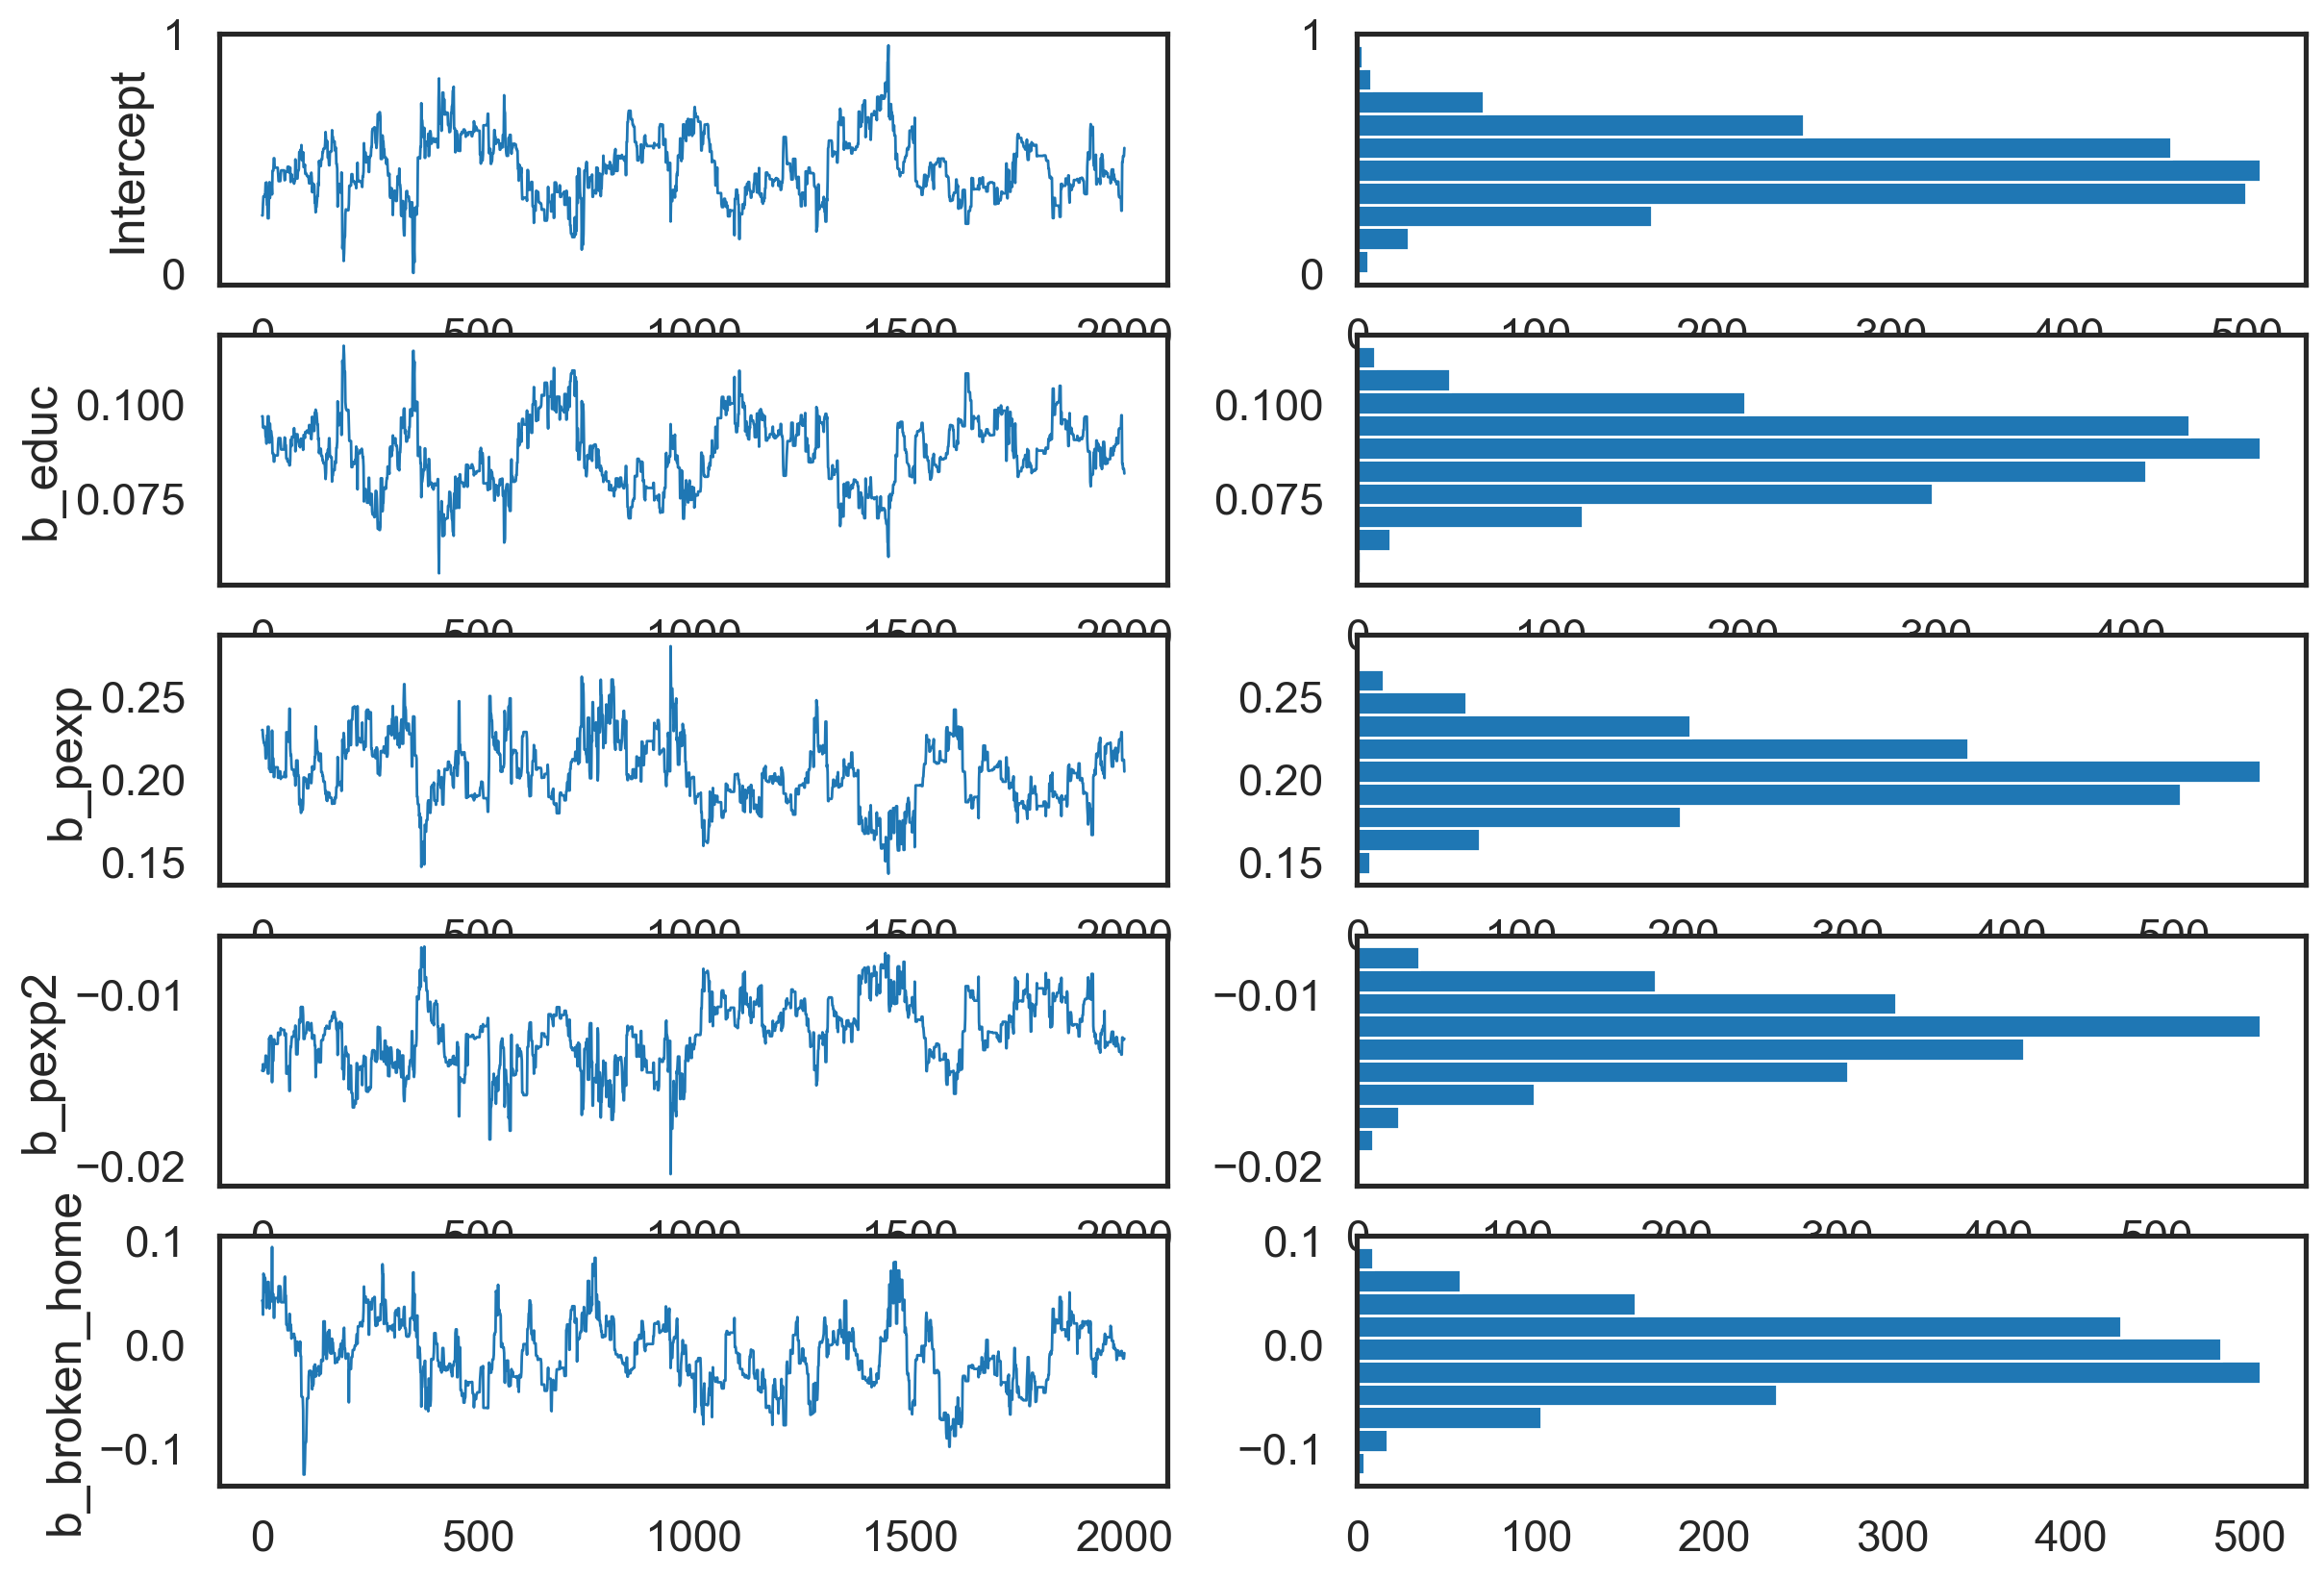

In [31]:
#Plot the entire chain:
time= np.arange(nsteps-nburn)  # x values for plot (integer count)
sample = sampler.chain[:, nburn:, :]

# plot point estimate and confidence intervals:
plt.figure(figsize=(14, 10), dpi=200)
lw = 1

# to show the full chain, need to loop through walkers, but we'll just show the first walker:
plt.subplot(521)
plt.ylabel("Intercept")
plt.plot(time, sample[1,:,4], label="Intercept",lw=lw)
plt.subplot(522)
plt.hist(sample[1,:,4],lw=lw, label="Intercept", orientation='horizontal')

plt.subplot(523)
plt.ylabel("b_educ")
plt.plot(time, sample[1,:,0], label="b_educ",lw=lw)
plt.subplot(524)
plt.hist(sample[1,:,0],lw=lw, label="b_educ",orientation='horizontal')

plt.subplot(525)
plt.ylabel("b_pexp")
plt.plot(time, sample[1,:,1], label="b_pexp",lw=lw)
plt.subplot(526)
plt.hist(sample[1,:,1],lw=lw, label="b_pexp",orientation='horizontal')

plt.subplot(527)
plt.ylabel("b_pexp2")
plt.plot(time, sample[1,:,2], label="b_pexp2",lw=lw)
plt.subplot(528)
plt.hist(sample[1,:,2],lw=lw,label="b_pexp2", orientation='horizontal')

plt.subplot(529)
plt.ylabel("b_broken_home")
plt.plot(time,sample[1,:,3], label="b_broken_home",lw=lw)
plt.subplot(5,2,10)
plt.hist(sample[1,:,3],lw=lw, label="b_broken_home",orientation='horizontal');

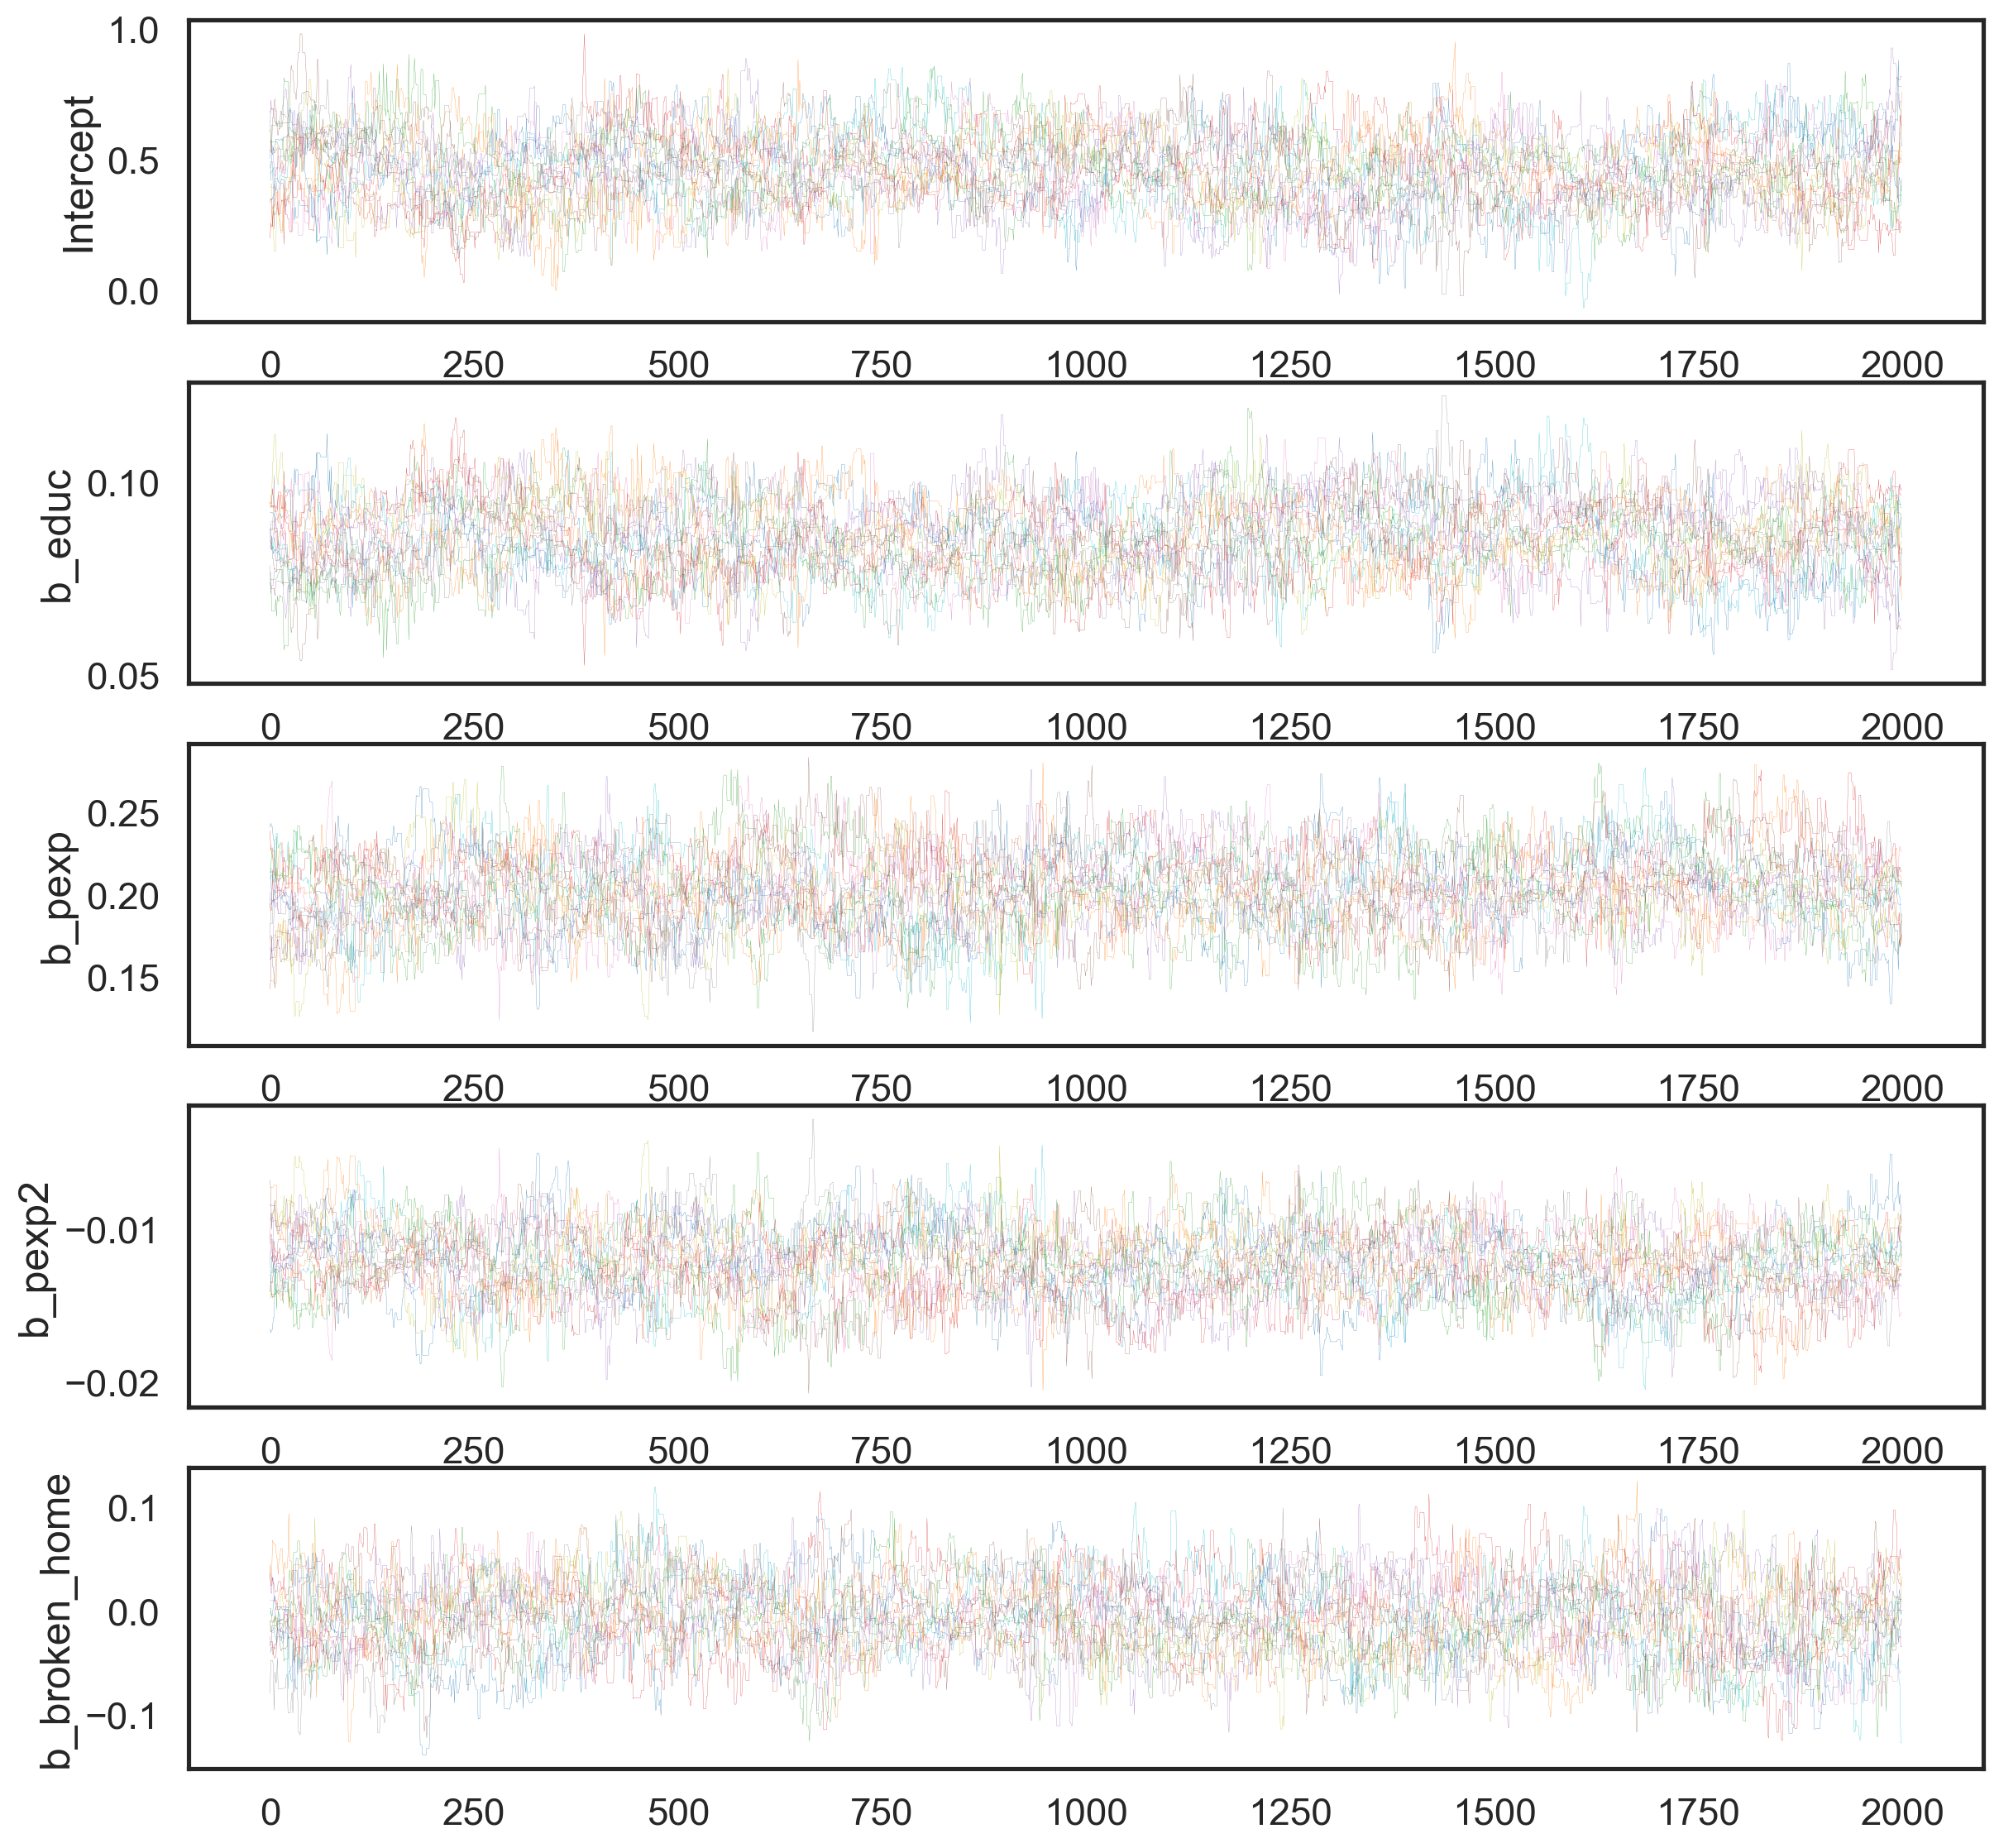

In [32]:
# to show the full chain, need to loop through walkers
walkers=np.arange(nwalkers)

plt.figure(figsize=(14, 14), dpi=200)

lw = .1

for i in walkers:
    plt.subplot(511)
    plt.ylabel("Intercept")
    plt.plot(time, sample[i,:,4], label="Intercept",lw=lw)

    plt.subplot(512)
    plt.ylabel("b_educ")
    plt.plot(time, sample[i,:,0], label="b_educ",lw=lw)

    plt.subplot(513)
    plt.ylabel("b_pexp")
    plt.plot(time, sample[i,:,1], label="b_pexp",lw=lw)
    
    plt.subplot(514)
    plt.ylabel("b_pexp2")
    plt.plot(time, sample[i,:,2], label="b_pexp2",lw=lw)

    plt.subplot(515)
    plt.ylabel("b_broken_home")
    plt.plot(time,sample[i,:,3], label="b_broken_home",lw=lw)


See discussion here: https://dfm.io/emcee/current/user/line/ Notice, using full set of walkers gives us a chain that at least visually does not have the periodicity problems (although there are formal tests), so we can proceed.  

Using the same information, the following plots the likelihood (posterior) surface in two dimensions. Each point in the diagrams is an actual parameter value that was included in our chain.

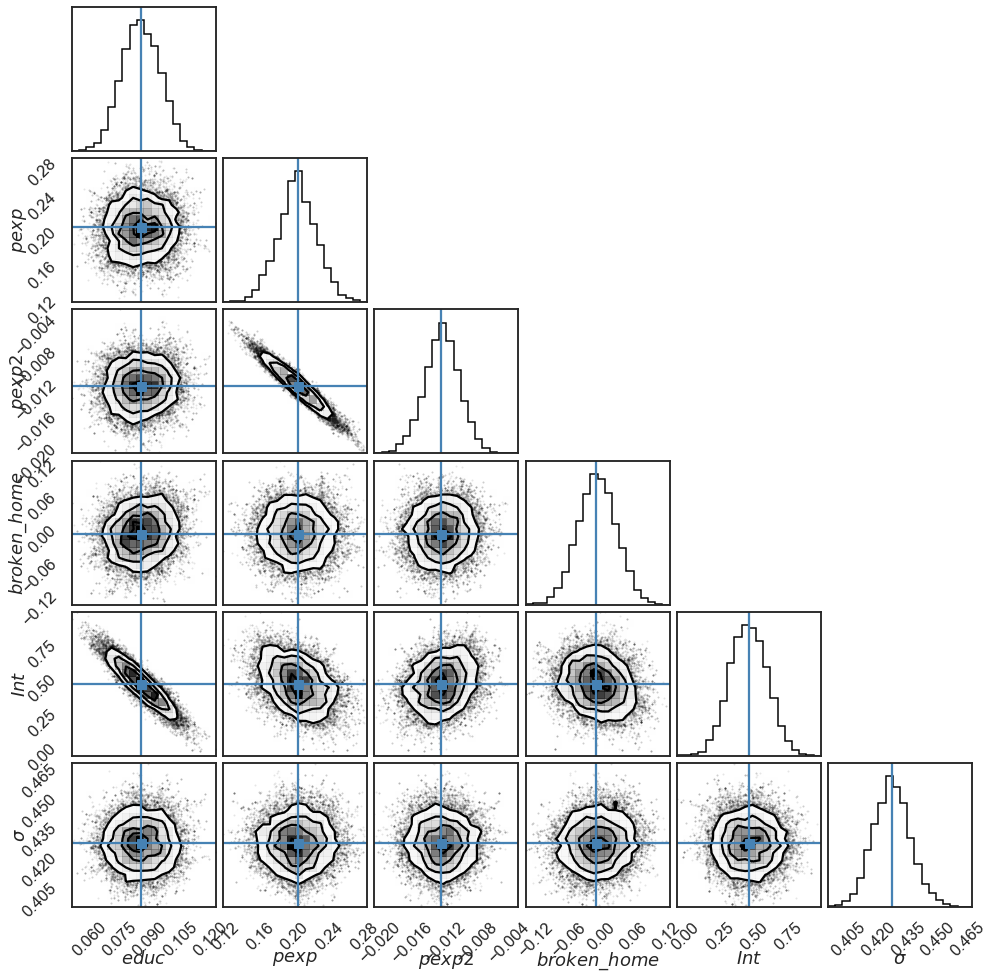

In [33]:
samples_long = sampler.chain[:, nburn:, :].reshape((-1, ndim))

fig = corner.corner(samples_long, labels=["$educ$", "$pexp$", "$pexp2$","$broken\_home$","$Int$","$\sigma$","$\ln\,L$"],
                      truths=[.0853, .2035, -.0124, -.0087, .4603, .4265, 0])

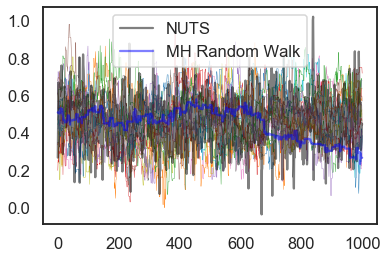

In [34]:
for i in walkers:
    plt.plot(np.arange(1000), sample[i,:1000,4], lw=.4)
plt.plot(np.arange(1000),trace_NUTS['Intercept'][1000:2000],label='NUTS',color='k',alpha=.5)
plt.plot(np.arange(1000),trace_mh['Intercept'][2000:3000],label='MH Random Walk',color='b',alpha=.5)

plt.legend();

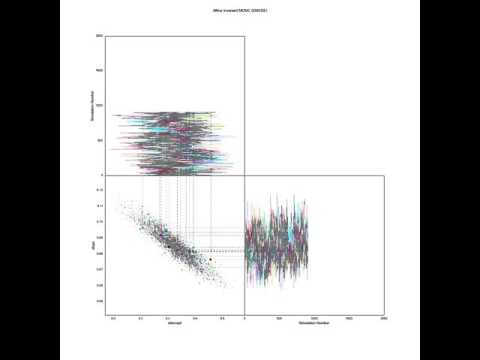

In [35]:
YouTubeVideo('aH8KCf4W8HY')

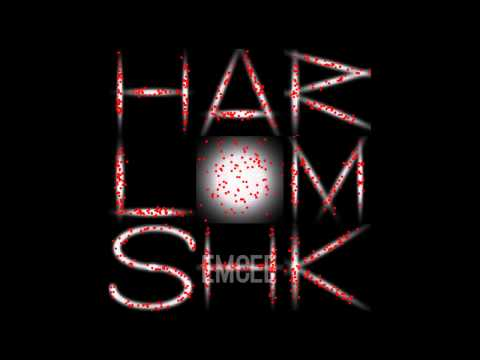

In [36]:
YouTubeVideo('yow7Ol88DRk')